## D

## Discretization

Using the **finite difference method**, the Laplacian operator $  \nabla^2  $ is approximated as:

$$
\nabla^2 u_{i,j} \approx \frac{1}{(\delta x)^2} \left[ u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4u_{i,j} \right]
$$

$$
\nabla^2 v_{i,j} \approx \frac{1}{(\delta x)^2} \left[ v_{i+1,j} + v_{i-1,j} + v_{i,j+1} + v_{i,j-1} - 4v_{i,j} \right]
$$

Using the **explicit Euler method**, we approximate the time derivative as:

$$
u(t + \delta t, x, y) \approx u(t, x, y) + \delta t \frac{\partial u}{\partial t}
$$

$$
v(t + \delta t, x, y) \approx v(t, x, y) + \delta t \frac{\partial v}{\partial t}
$$

Substituting the governing equations into these approximations, we obtain:

$$
u_{i,j}^{n+1} = u_{i,j}^{n} + \delta t \left( D_u \nabla^2 u_{i,j} - u_{i,j} v_{i,j}^2 + f (1 - u_{i,j}) \right)
$$

$$
v_{i,j}^{n+1} = v_{i,j}^{n} + \delta t \left( D_v \nabla^2 v_{i,j} + u_{i,j} v_{i,j}^2 - (f + k)v_{i,j} \right)
$$

**Final Iterative Update Scheme:**

$$
u_{i,j}^{n+1} = u_{i,j}^{n} + \delta t \left[ D_u \frac{u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4u_{i,j}}{(\delta x)^2} - u_{i,j} v_{i,j}^2 + f(1 - u_{i,j}) \right]
$$

$$
v_{i,j}^{n+1} = v_{i,j}^{n} + \delta t \left[ D_v \frac{v_{i+1,j} + v_{i-1,j} + v_{i,j+1} + v_{i,j-1} - 4v_{i,j}}{(\delta x)^2} + u_{i,j} v_{i,j}^2 - (f + k)v_{i,j} \right]
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Create directory for figures
if not os.path.exists("figures"):
    os.makedirs("figures")

# Grid size and parameters
N = 100  
delta_t = 1.0  
delta_x = 1.0  
tolerance = 1e-5  # Convergence threshold

# Laplacian function with Dirichlet boundary conditions
def laplacian_dirichlet(Z, fixed_value=0):
    """Compute Laplacian with Dirichlet (fixed value) boundary conditions"""
    result = np.zeros_like(Z)
    result[1:-1, 1:-1] = (
        Z[:-2, 1:-1] + Z[2:, 1:-1] + Z[1:-1, :-2] + Z[1:-1, 2:] - 4 * Z[1:-1, 1:-1]
    ) / (delta_x ** 2)
    result[0, :] = fixed_value
    result[-1, :] = fixed_value
    result[:, 0] = fixed_value
    result[:, -1] = fixed_value
    return result

# Gray-Scott model function with automatic convergence check
def gray_scott(Du, Dv, f, k, noise, max_iter=50000):
    """Simulate the Gray-Scott model with Dirichlet boundary conditions and automatic termination"""
    U = np.ones((N, N)) * 0.5 + np.abs(noise * np.random.randn(N, N))  
    V = np.zeros((N, N))

    # Initial perturbation in the center
    r = 10
    center = N // 2
    U[center-r:center+r, center-r:center+r] = 0.5
    V[center-r:center+r, center-r:center+r] = 0.25

    for iter_count in range(max_iter):
        Lu = laplacian_dirichlet(U, fixed_value=0.5)  
        Lv = laplacian_dirichlet(V, fixed_value=0)    

        # Compute update step
        delta_u = (Du * Lu - U * V**2 + f * (1 - U)) * delta_t
        delta_v = (Dv * Lv + U * V**2 - (f + k) * V) * delta_t

        # Check convergence
        if np.max(np.abs(delta_u[1:-1, 1:-1])) < tolerance and np.max(np.abs(delta_v[1:-1, 1:-1])) < tolerance:
            print(f"Simulation converged at step {iter_count}")
            break

        U += delta_u
        V += delta_v

        # Enforce Dirichlet boundary conditions
        U[0, :], U[-1, :], U[:, 0], U[:, -1] = 0.5, 0.5, 0.5, 0.5
        V[0, :], V[-1, :], V[:, 0], V[:, -1] = 0, 0, 0, 0

    return U, V  

# Plot result
def plot_result(U, V, params, experiment_name):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Set titles
    title_text = f"Du={params['Du']}, Dv={params['Dv']}, f={params['f']}, k={params['k']}, noise={params['noise']}"

    # Plot U
    im1 = axes[0].imshow(U, cmap="inferno", interpolation="bilinear")
    axes[0].set_title("U Concentration", fontsize=12)
    fig.colorbar(im1, ax=axes[0])

    # Plot V
    im2 = axes[1].imshow(V, cmap="magma", interpolation="bilinear")
    axes[1].set_title("V Concentration", fontsize=12)
    fig.colorbar(im2, ax=axes[1])

    # Use suptitle for the main parameter title
    fig.suptitle(title_text, fontsize=14)
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Define filename format
    filename = f"figures/{experiment_name}_Du{params['Du']}_Dv{params['Dv']}_f{params['f']}_k{params['k']}_noise{params['noise']}.png"

    plt.savefig(filename, dpi=300, bbox_inches="tight")  # Save figure

    plt.show()

    plt.close(fig)


### Effect of $D_u$

Simulation converged at step 289


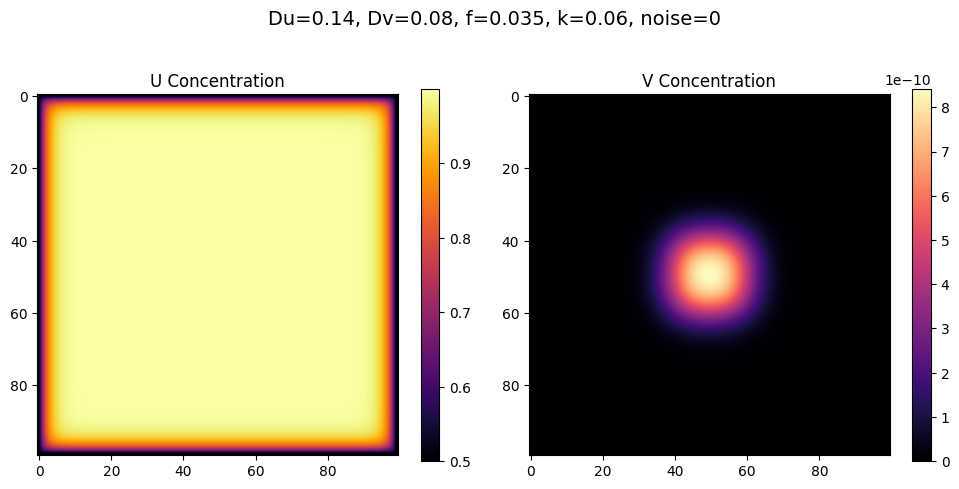

Simulation converged at step 30954


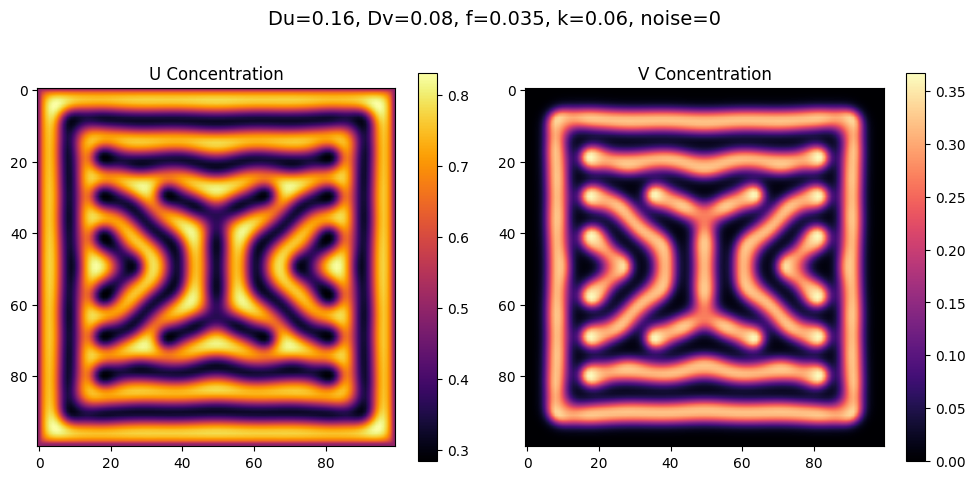

Simulation converged at step 13323


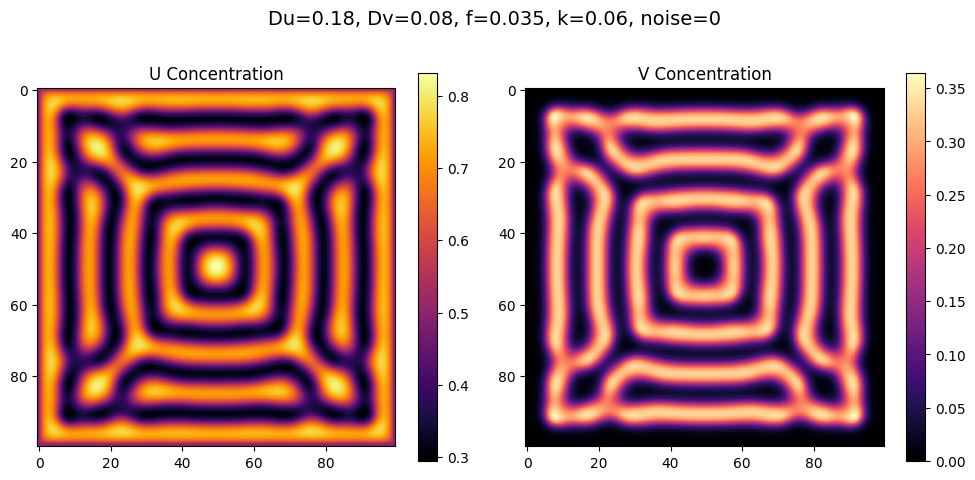

In [2]:
experiment_name = "Effect_of_Du"
du_values = [0.14, 0.16, 0.18]

for du in du_values:
    params = {"Du": du, "Dv": 0.08, "f": 0.035, "k": 0.06, "noise": 0}
    U, V = gray_scott(**params)
    plot_result(U, V, params, experiment_name)


### Effect of $D_v$

Simulation converged at step 9918


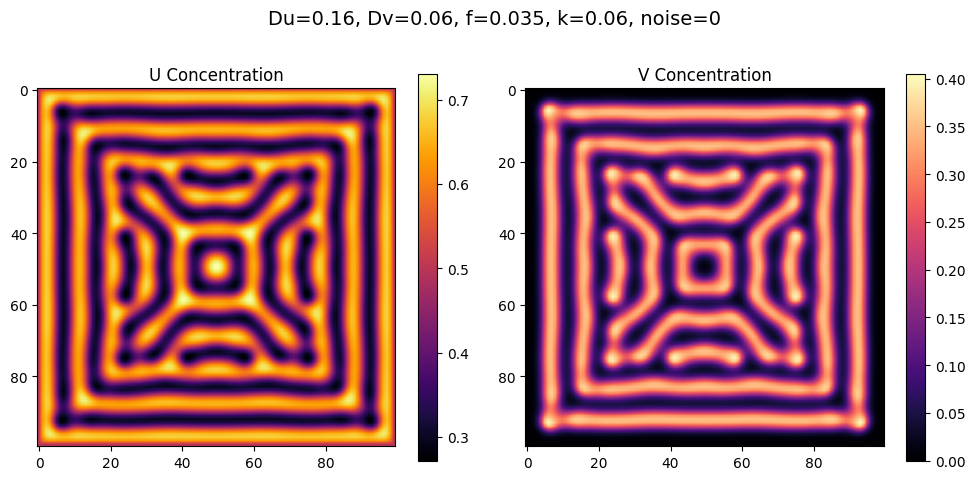

Simulation converged at step 30954


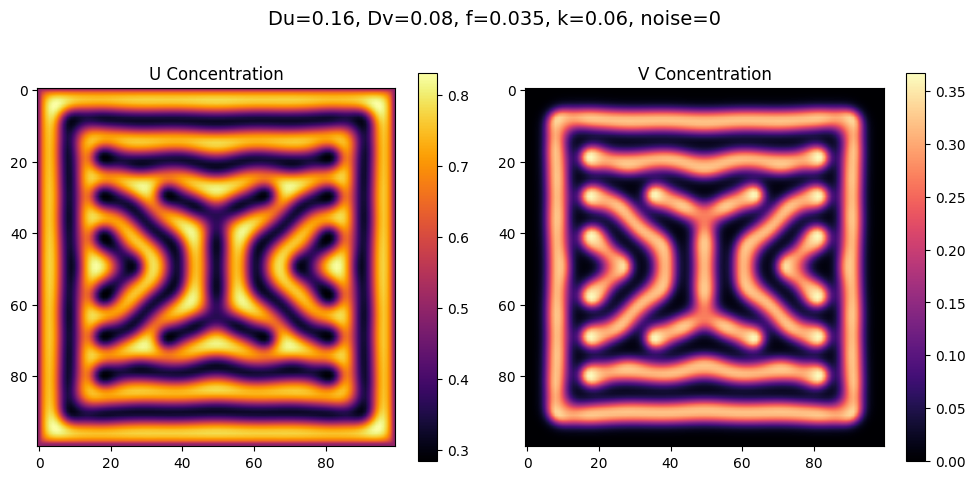

Simulation converged at step 283


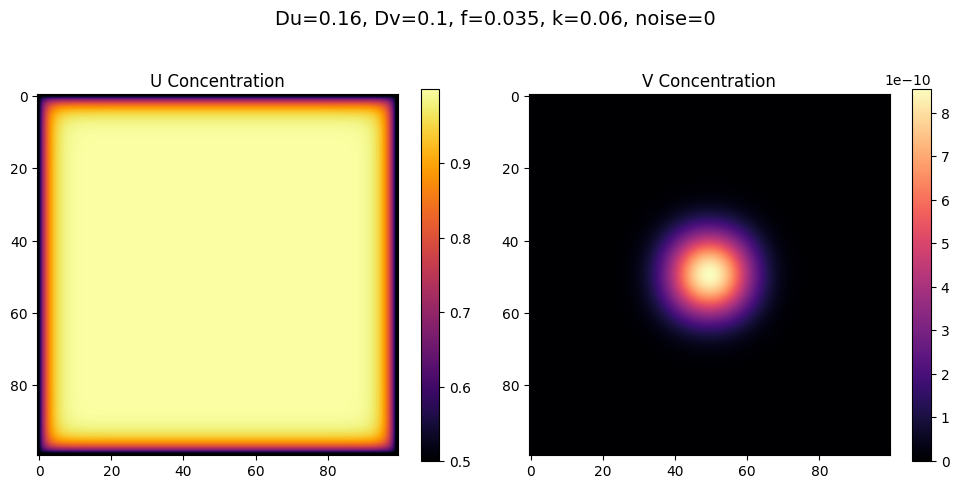

In [3]:
experiment_name = "Effect_of_Dv"
dv_values = [0.06, 0.08, 0.10]

for dv in dv_values:
    params = {"Du": 0.16, "Dv": dv, "f": 0.035, "k": 0.06, "noise": 0}
    U, V = gray_scott(**params)
    plot_result(U, V, params, experiment_name)


### Effect of $f$

Simulation converged at step 336


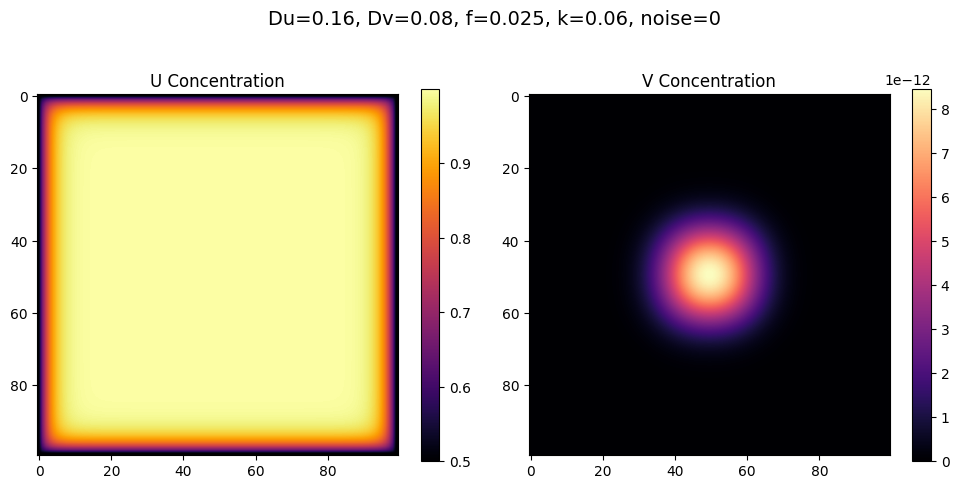

Simulation converged at step 30954


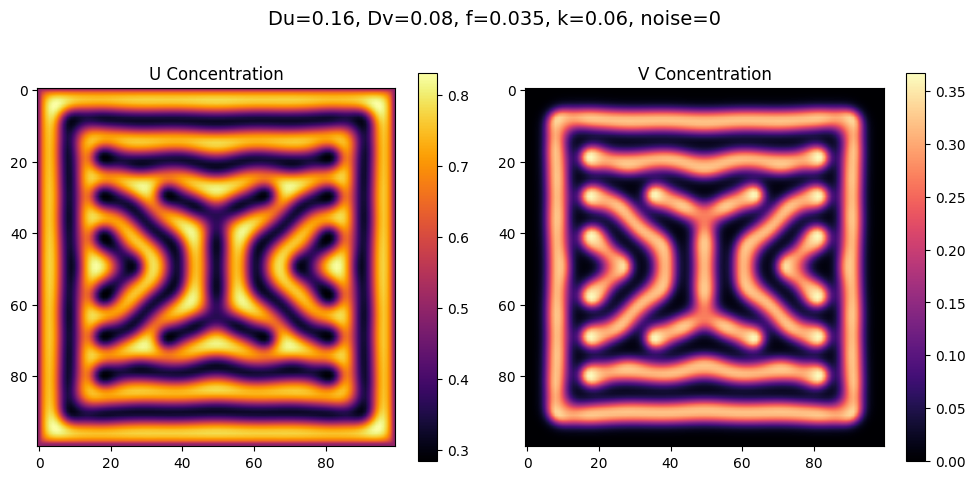

Simulation converged at step 9765


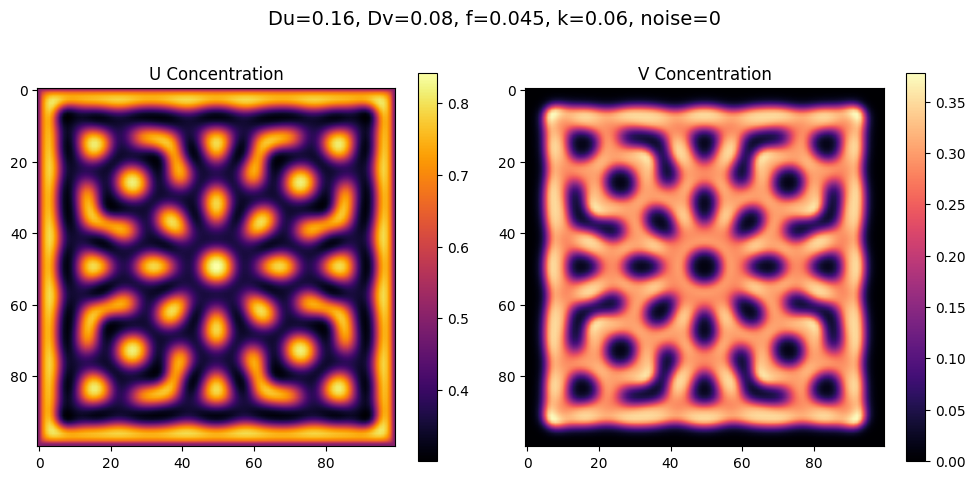

In [4]:
experiment_name = "Effect_of_f"
f_values = [0.025, 0.035, 0.045]

for f in f_values:
    params = {"Du": 0.16, "Dv": 0.08, "f": f, "k": 0.06, "noise": 0}
    U, V = gray_scott(**params)
    plot_result(U, V, params, experiment_name)


### Effect of $k$

Simulation converged at step 1296


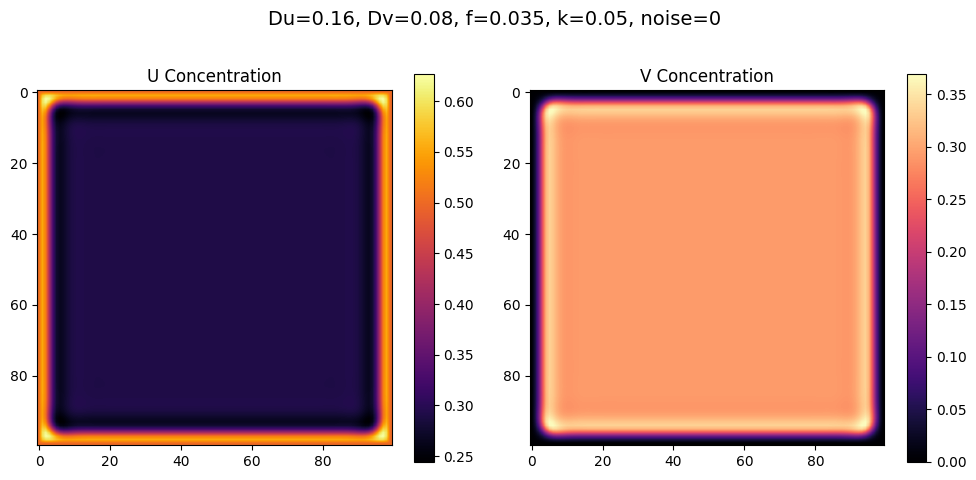

Simulation converged at step 30954


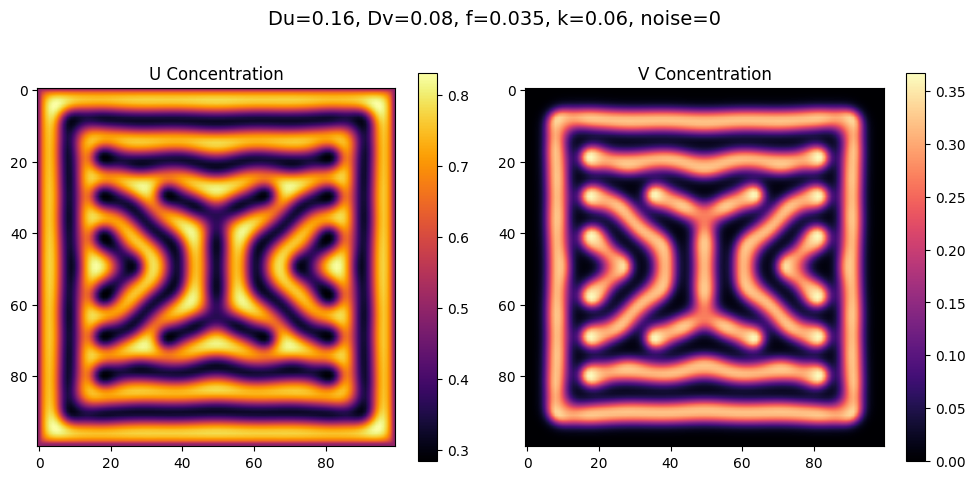

Simulation converged at step 248


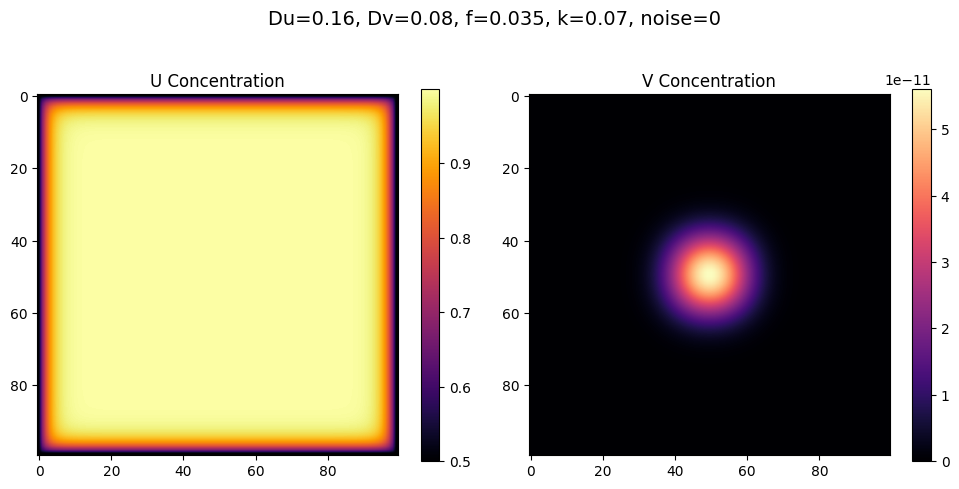

In [5]:
experiment_name = "Effect_of_k"
k_values = [0.05, 0.06, 0.07]

for k in k_values:
    params = {"Du": 0.16, "Dv": 0.08, "f": 0.035, "k": k, "noise": 0}
    U, V = gray_scott(**params)
    plot_result(U, V, params, experiment_name)


### Effect of noise

Simulation converged at step 35770


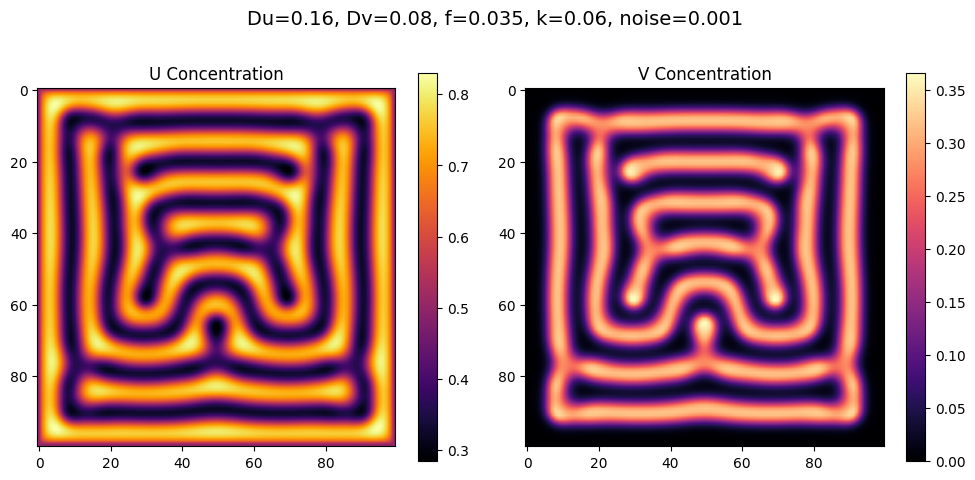

Simulation converged at step 46259


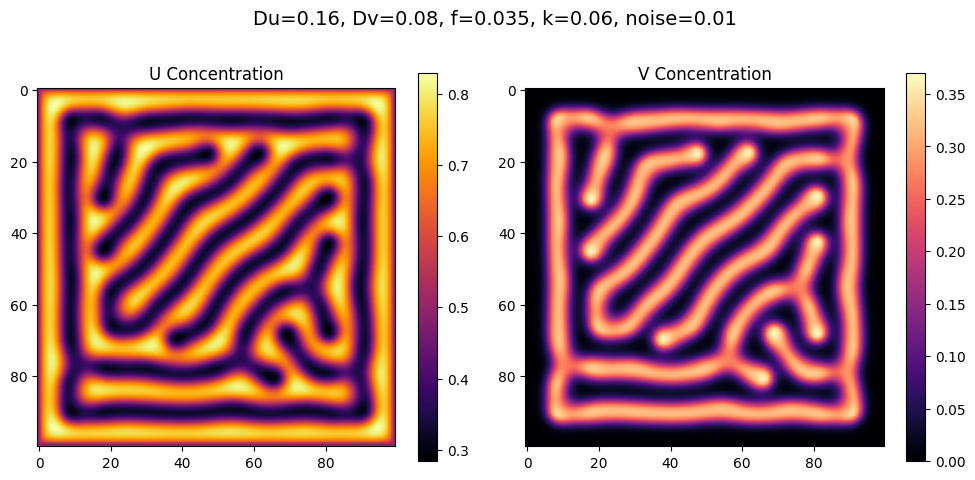

In [6]:
experiment_name = "Effect_of_Noise"
noise_values = [0.001, 0.01]

for noise in noise_values:
    params = {"Du": 0.16, "Dv": 0.08, "f": 0.035, "k": 0.06, "noise": noise}
    U, V = gray_scott(**params)
    plot_result(U, V, params, experiment_name)
